In [1]:
%cd ..

/home/jairo/Documentos/GitHub/kink-antikink-parellel


In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from pathlib import Path

from modules.numerical import Lattice, Diff

In [3]:
def read(filename):
    return pd.read_csv(filename, index_col=0)

def imshow(y, x, t, ax=None, **kwargs):
    (plt if ax == None else ax).imshow(y, extent=(t.min(), t.max(), x.min(), x.max()), origin='lower', **kwargs)

In [4]:
path = Path('data/dataset/')
files = tuple(path.glob('*'))

In [230]:
i = np.random.randint(len(files))
df = read(files[i]).T
y = df.values
t = df.index.values.astype(float)
x = df.columns.values.astype(float)
lat = Lattice()
lat.ranges = [t, x]

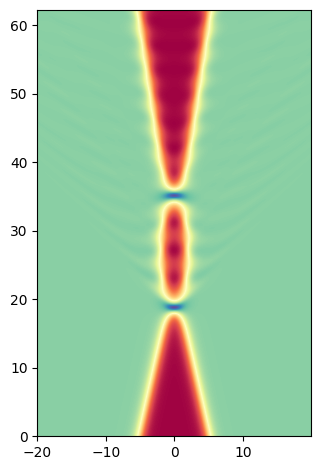

In [231]:
_, wx = lat.window(..., (-20, 20))
imshow(y[:, wx], t, x[wx], cmap='Spectral_r', aspect='equal')

plt.gcf().tight_layout()
plt.show()

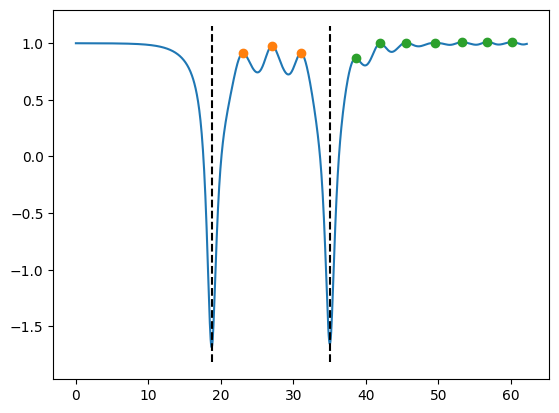

In [232]:
cm = y[*lat.at(..., 0)]
peaks, _ = find_peaks(cm**2, prominence=1.5)

plt.plot(t, cm)
plt.vlines(t[peaks], *plt.gca().get_ylim(), colors='k', linestyles='dashed')

for i in range(len(peaks) - 1):
    bounce = (t > t[peaks][i]) & (t < t[peaks][i+1])
    mini_peaks, _ = find_peaks(cm[bounce])
    plt.plot(t[bounce][mini_peaks], cm[bounce][mini_peaks], 'o')
bounce = t > t[peaks][-1]
mini_peaks, _ = find_peaks(cm[bounce])
plt.plot(t[bounce][mini_peaks], cm[bounce][mini_peaks], 'o')

plt.show()

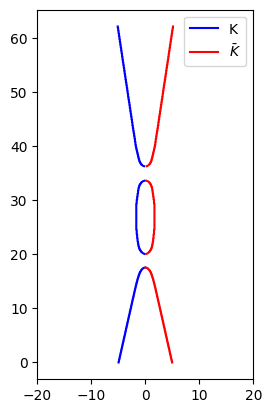

In [233]:
k1, k2 = [], []
for i in range(len(t)):
    x_slice = x[y[i] >= 0]
    if len(x_slice) == 0:
        k1.append(np.nan)
        k2.append(np.nan)
    else:
        k1.append(x_slice.min())
        k2.append(x_slice.max())
k1, k2 = np.r_[k1], np.r_[k2]

plt.plot(k1, t, 'b-', label=r'K')
plt.plot(k2, t, 'r-', label=r'$\bar{K}$')
plt.legend()
plt.gca().set_aspect('equal')
plt.xlim(-20, 20)

plt.show()

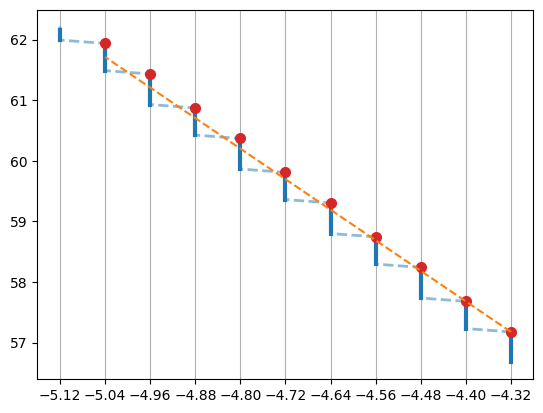

In [234]:
Q = 100
plt.plot(k1[-Q:], t[-Q:], 'C0--', lw=2, alpha=0.5)

vs = np.diff(k1[-Q:])
for slc in np.ma.clump_masked(np.ma.masked_equal(vs, 0)):
    plt.plot(k1[-Q:][slc], t[-Q:][slc], 'C0-', lw=3)

vertex = np.argwhere(vs != 0).ravel()
plt.plot(k1[-Q:][vertex], t[-Q:][vertex], 'C3o', markersize=7) # t = ax + b => b = t - ax

v1, v2 = vertex[:2]
delta_t = -t[-Q:][v2] + t[-Q:][v1]
dx = x[1] - x[0]
a = delta_t/dx

b = t[-Q:][vertex[0]] - k1[-Q:][vertex[0]]*a
X_v = np.linspace(k1[-Q:][vertex[0]], k1[-Q:][vertex[-1]], 25)
plt.plot(X_v, X_v*a + b, 'C1--')

# plt.legend()
plt.grid(axis='x')
k1_unique = np.unique(k1[-Q:])
plt.xticks(k1_unique[~np.isnan(k1_unique)])
plt.show()

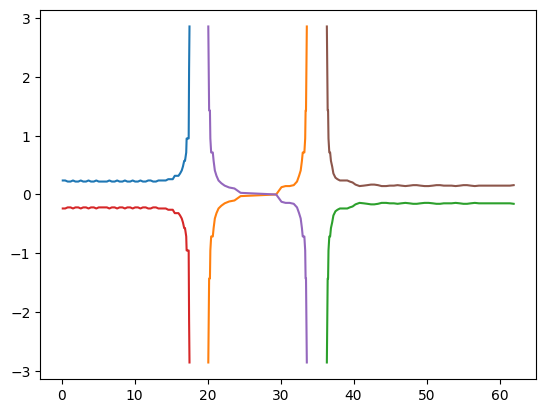

In [235]:
for k in (k1, k2):
    for slc in np.ma.clump_unmasked(np.ma.masked_invalid(k)):
        vertex = np.argwhere(np.diff(k[slc]) != 0)
        plt.plot(t[slc][vertex].ravel(), np.gradient(k[slc][vertex].ravel())/np.gradient(t[slc][vertex].ravel()))
plt.show()

In [19]:
from celluloid import Camera
from IPython.display import HTML

def show(animation):
    plt.close()
    return HTML(animation.to_html5_video())

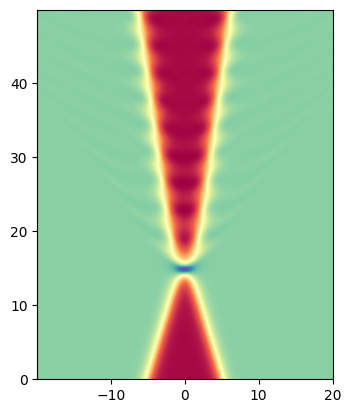

In [28]:
fig = plt.figure()
fig.tight_layout()

camera = Camera(fig)

vs = [float(filename.stem.split('-v:')[-1]) for filename in files]
for i in np.argsort(vs):
    df = read(files[i]).T
    y = df.values
    t = df.index.values.astype(float)
    loc = t < 50
    imshow(y[loc][:, w], t[loc], x[w], cmap='Spectral_r', aspect='equal')
    camera.snap()

In [30]:
show(camera.animate(interval=50))